In [2]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    

GPU is available


# MLP 

In [4]:
class MLPNet(nn.Module):
    def __init__(self, 
                 in_dim, # input dimension
                 out_dim, # output dimension
                 hidden_dim, # hidden dimension
                 num_layers # number of layers
                ):
        
        super(MLPNet, self).__init__()
        
        self.model = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        
        for i in range(num_layers-2):
            self.model += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        
        self.model += [nn.Linear(hidden_dim, out_dim)]
        
        self.model = nn.Sequential(*self.model)
        
    def forward(self, inp):
        
        # Flatten the last two dimensions
        inp = inp.reshape(inp.shape[0], -1)
        
        out = self.model(inp)
        
        #bz x outputlength x 2
        return out.reshape(inp.shape[0], -1, 2)

In [3]:
# Autogressive vs. direct mapping
# Batch Norm? 

# Dataset

In [5]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
        # input: p_in & v_in; output: p_out
        inp_scene = np.dstack([scene['p_in'], scene['v_in']])
        out_scene = np.dstack([scene['p_out'], scene['v_out']])
        
        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        # Normalize by vectors
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        # Convert to float torch tensor
        return torch.from_numpy(inp).float(), torch.from_numpy(out[:,:2]).float()

In [5]:
# Try different ways of normalization
# Leverage other features. 

# Hyperparameter

In [6]:
# Grid/Random Search

In [6]:
# batch_size = 64
batch_size = 512
in_dim = 19*4
out_dim = 30*2
hidden_dim = 128
num_layers = 3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

# Data Loader

In [6]:
# train_path = "./train/train"

# # total number of scenes
# indices = np.arange(0, 1000)

# # train-valid split
# np.random.shuffle(indices)
# train_indices = indices[:900]
# valid_indices = indices[900:]

# # define datasets
# train_set = ArgoverseDataset(train_path, train_indices)
# valid_set = ArgoverseDataset(train_path, valid_indices)

# # create dataloaders
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
# valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [7]:
train_path = "./train/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

# Model, Loss Function and Optimizer

In [8]:
# RNN, LSTM, 1dCNN, Transformer
model = MLPNet(in_dim = in_dim, 
               out_dim = out_dim,
               hidden_dim = hidden_dim, 
               num_layers = num_layers).to(device) # move model to gpu 

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

In [9]:
model.load_state_dict(torch.load('baseline.pt'))

<All keys matched successfully>

In [12]:
train_path = "./train/train/"
train_pkl_list = glob(os.path.join(train_path, '*'))
train_pkl_list.sort()

train_preds = []
for idx in range(3):
    with open(train_pkl_list[idx], 'rb') as f:
        train_sample = pickle.load(f)
        pred_id = np.where(train_sample["track_id"] == train_sample['agent_id'])[0][0]
        inp_scene = np.dstack([train_sample['p_in'], train_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = model(inp).cpu().data.numpy()
        
        # De-Normalization ! 
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        train_preds.append(preds)

In [14]:
predictions = np.concatenate(train_preds).reshape(len(train_preds), -1).astype(int)

In [16]:
predictions.shape

(3, 60)

In [ ]:
predictions

# Training

In [10]:
len(train_loader)

352

In [11]:
def train_epoch(train_loader, model, optimizer, loss_function):
    train_mse = []
    for inp, tgt in tqdm(train_loader):
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        #print("starting pred")
        pred = model(inp)
        #print("make pred")
        
        loss = loss_function(pred, tgt)
        train_mse.append(loss.item()) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    valid_mse = []
    preds = []
    trues = []
    with torch.no_grad():
        for inp, tgt in valid_loader:
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            pred = model(inp)
            loss = loss_function(pred, tgt)
            preds.append(pred.cpu().data.numpy())
            trues.append(tgt.cpu().data.numpy())
            valid_mse.append(loss.item())
            
        preds = np.concatenate(preds, axis = 0)  
        trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse, preds, trues


In [14]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

In [ ]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in tqdm(range(num_epoch)):
    start = time.time()

    # model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    #print(train_rmse)
    
    # model.eval()
    val_rmse, val_preds, val_trues = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

torch.save(model.state_dict(), 'baseline.pt')

plt.figure()
plt.plot(train_rmse)
plt.plot(valid_rmse)
plt.xlabel('epochs')
plt.ylabel('RSME loss')
plt.savefig('loss_curve.png')
plt.show()

 88%|████████▊ | 309/352 [04:03<00:38,  1.13it/s]


  0%|          | 1/1000 [05:27<90:56:33, 327.72s/it]

Epoch 1 | T: 5.46 | Train RMSE: 0.08730 | Valid RMSE: 0.02365



 88%|████████▊ | 309/352 [04:20<00:43,  1.01s/it]


  0%|          | 2/1000 [11:16<94:20:00, 340.28s/it]

Epoch 2 | T: 5.82 | Train RMSE: 0.02255 | Valid RMSE: 0.02309



 88%|████████▊ | 309/352 [04:25<00:40,  1.07it/s]


  0%|          | 3/1000 [17:11<96:05:18, 346.96s/it]

Epoch 3 | T: 5.92 | Train RMSE: 0.02105 | Valid RMSE: 0.01577



 88%|████████▊ | 309/352 [04:24<00:38,  1.12it/s]


  0%|          | 4/1000 [23:04<96:36:46, 349.20s/it]

Epoch 4 | T: 5.88 | Train RMSE: 0.01890 | Valid RMSE: 0.01479



 88%|████████▊ | 309/352 [04:24<00:40,  1.05it/s]


  0%|          | 5/1000 [28:56<96:50:20, 350.37s/it]

Epoch 5 | T: 5.87 | Train RMSE: 0.01852 | Valid RMSE: 0.01496



 88%|████████▊ | 309/352 [04:23<00:46,  1.08s/it]


  1%|          | 6/1000 [35:00<97:57:16, 354.76s/it]

Epoch 6 | T: 6.05 | Train RMSE: 0.01760 | Valid RMSE: 0.01715



 59%|█████▉    | 208/352 [03:10<02:19,  1.03it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  1%|          | 12/1000 [1:10:33<96:26:26, 351.40s/it]

Epoch 12 | T: 5.80 | Train RMSE: 0.01414 | Valid RMSE: 0.01289



 88%|████████▊ | 309/352 [04:24<00:46,  1.07s/it]


  1%|▏         | 13/1000 [1:16:24<96:18:22, 351.27s/it]

Epoch 13 | T: 5.85 | Train RMSE: 0.01355 | Valid RMSE: 0.01320



 88%|████████▊ | 309/352 [04:20<00:40,  1.05it/s]


  1%|▏         | 14/1000 [1:22:12<95:57:27, 350.35s/it]

Epoch 14 | T: 5.80 | Train RMSE: 0.01283 | Valid RMSE: 0.01061



 88%|████████▊ | 309/352 [04:23<00:40,  1.07it/s]


  2%|▏         | 15/1000 [1:28:03<95:57:01, 350.68s/it]

Epoch 15 | T: 5.86 | Train RMSE: 0.01229 | Valid RMSE: 0.00952



 88%|████████▊ | 309/352 [04:23<00:41,  1.03it/s]


  2%|▏         | 16/1000 [1:33:54<95:50:08, 350.62s/it]

Epoch 16 | T: 5.84 | Train RMSE: 0.01486 | Valid RMSE: 0.01146



 88%|████████▊ | 309/352 [04:23<00:39,  1.08it/s]


  2%|▏         | 17/1000 [1:39:45<95:45:56, 350.72s/it]

Epoch 17 | T: 5.85 | Train RMSE: 0.01067 | Valid RMSE: 0.01055



 88%|████████▊ | 309/352 [04:23<00:39,  1.09it/s]


  2%|▏         | 18/1000 [1:45:35<95:36:26, 350.49s/it]

Epoch 18 | T: 5.83 | Train RMSE: 0.01062 | Valid RMSE: 0.00917



 88%|████████▊ | 309/352 [04:17<00:39,  1.09it/s]


  2%|▏         | 19/1000 [1:51:19<94:59:51, 348.62s/it]

Epoch 19 | T: 5.74 | Train RMSE: 0.01073 | Valid RMSE: 0.01507



 88%|████████▊ | 309/352 [04:19<00:39,  1.08it/s]


  2%|▏         | 20/1000 [1:57:06<94:45:07, 348.07s/it]

Epoch 20 | T: 5.78 | Train RMSE: 0.00983 | Valid RMSE: 0.01812



 88%|████████▊ | 309/352 [04:18<00:39,  1.09it/s]


  2%|▏         | 21/1000 [2:02:50<94:20:27, 346.91s/it]

Epoch 21 | T: 5.74 | Train RMSE: 0.00951 | Valid RMSE: 0.00897



 88%|████████▊ | 309/352 [04:20<00:40,  1.07it/s]


  2%|▏         | 22/1000 [2:08:37<94:15:34, 346.97s/it]

Epoch 22 | T: 5.78 | Train RMSE: 0.00912 | Valid RMSE: 0.00959



 88%|████████▊ | 309/352 [04:19<00:39,  1.09it/s]


  2%|▏         | 23/1000 [2:14:23<94:05:58, 346.73s/it]

Epoch 23 | T: 5.77 | Train RMSE: 0.00929 | Valid RMSE: 0.00827



 88%|████████▊ | 309/352 [04:19<00:39,  1.08it/s]


  2%|▏         | 24/1000 [2:20:09<93:54:48, 346.40s/it]

Epoch 24 | T: 5.76 | Train RMSE: 0.00904 | Valid RMSE: 0.01007



 88%|████████▊ | 309/352 [04:22<00:39,  1.08it/s]


  2%|▎         | 25/1000 [2:25:58<94:04:10, 347.33s/it]

Epoch 25 | T: 5.83 | Train RMSE: 0.00864 | Valid RMSE: 0.00779



 88%|████████▊ | 309/352 [04:24<00:40,  1.07it/s]


  3%|▎         | 26/1000 [2:31:50<94:16:58, 348.48s/it]

Epoch 26 | T: 5.85 | Train RMSE: 0.00858 | Valid RMSE: 0.01244



 88%|████████▊ | 309/352 [04:17<00:37,  1.15it/s]


  3%|▎         | 27/1000 [2:37:29<93:25:29, 345.66s/it]

Epoch 27 | T: 5.65 | Train RMSE: 0.00847 | Valid RMSE: 0.00757



 88%|████████▊ | 309/352 [04:08<00:37,  1.14it/s]


  3%|▎         | 28/1000 [2:42:59<92:07:17, 341.19s/it]

Epoch 28 | T: 5.51 | Train RMSE: 0.00833 | Valid RMSE: 0.00962



 76%|███████▋  | 269/352 [03:31<01:12,  1.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


 21%|██        | 73/352 [00:46<02:58,  1.56it/s]


  4%|▎         | 35/1000 [3:19:38<82:51:50, 309.13s/it]

Epoch 35 | T: 4.91 | Train RMSE: 0.00738 | Valid RMSE: 0.00660



 88%|████████▊ | 309/352 [03:55<00:40,  1.07it/s]


  4%|▎         | 36/1000 [3:25:00<83:51:59, 313.19s/it]

Epoch 36 | T: 5.38 | Train RMSE: 0.00721 | Valid RMSE: 0.00709



 88%|████████▊ | 309/352 [04:21<00:40,  1.05it/s]


 93%|█████████▎| 329/352 [04:40<00:21,  1.07it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


  4%|▍         | 38/1000 [3:35:56<85:19:17, 319.29s/it]

Epoch 38 | T: 5.20 | Train RMSE: 0.00695 | Valid RMSE: 0.00772



 88%|████████▊ | 309/352 [03:56<00:36,  1.18it/s]


  4%|▍         | 39/1000 [3:41:12<84:55:06, 318.11s/it]

Epoch 39 | T: 5.26 | Train RMSE: 0.00700 | Valid RMSE: 0.00632



 88%|████████▊ | 309/352 [03:55<00:36,  1.19it/s]


  4%|▍         | 40/1000 [3:46:27<84:35:49, 317.24s/it]

Epoch 40 | T: 5.25 | Train RMSE: 0.00671 | Valid RMSE: 0.00661



 88%|████████▊ | 309/352 [03:55<00:40,  1.05it/s]


  4%|▍         | 41/1000 [3:51:40<84:13:13, 316.16s/it]

Epoch 41 | T: 5.23 | Train RMSE: 0.00668 | Valid RMSE: 0.00616



 88%|████████▊ | 309/352 [03:51<00:34,  1.25it/s]


  4%|▍         | 42/1000 [3:56:46<83:16:28, 312.93s/it]

Epoch 42 | T: 5.09 | Train RMSE: 0.00662 | Valid RMSE: 0.00643



 88%|████████▊ | 309/352 [03:44<00:34,  1.26it/s]


  4%|▍         | 43/1000 [4:01:45<82:03:18, 308.67s/it]

Epoch 43 | T: 4.98 | Train RMSE: 0.00637 | Valid RMSE: 0.00593



 88%|████████▊ | 309/352 [03:42<00:35,  1.23it/s]


  4%|▍         | 44/1000 [4:06:44<81:13:03, 305.84s/it]

Epoch 44 | T: 4.99 | Train RMSE: 0.00628 | Valid RMSE: 0.00644



 88%|████████▊ | 309/352 [03:57<00:36,  1.19it/s]


  4%|▍         | 45/1000 [4:12:00<81:58:57, 309.04s/it]

Epoch 45 | T: 5.28 | Train RMSE: 0.00615 | Valid RMSE: 0.00791



 88%|████████▊ | 309/352 [03:57<00:36,  1.19it/s]


  5%|▍         | 46/1000 [4:17:17<82:28:39, 311.24s/it]

Epoch 46 | T: 5.27 | Train RMSE: 0.00607 | Valid RMSE: 0.00569



 88%|████████▊ | 309/352 [03:54<00:36,  1.19it/s]


  5%|▍         | 47/1000 [4:22:31<82:37:28, 312.12s/it]

Epoch 47 | T: 5.24 | Train RMSE: 0.00587 | Valid RMSE: 0.00629



 88%|████████▊ | 309/352 [03:58<00:36,  1.17it/s]


  5%|▍         | 48/1000 [4:27:48<82:54:32, 313.52s/it]

Epoch 48 | T: 5.28 | Train RMSE: 0.00580 | Valid RMSE: 0.00547



 88%|████████▊ | 309/352 [03:58<00:35,  1.20it/s]


  5%|▍         | 49/1000 [4:33:05<83:08:45, 314.75s/it]

Epoch 49 | T: 5.29 | Train RMSE: 0.00563 | Valid RMSE: 0.00655



 88%|████████▊ | 309/352 [03:55<00:36,  1.18it/s]


  5%|▌         | 50/1000 [4:38:20<83:02:24, 314.68s/it]

Epoch 50 | T: 5.24 | Train RMSE: 0.00557 | Valid RMSE: 0.00623



 88%|████████▊ | 309/352 [03:57<00:34,  1.26it/s]


  5%|▌         | 51/1000 [4:43:37<83:07:11, 315.31s/it]

Epoch 51 | T: 5.28 | Train RMSE: 0.00552 | Valid RMSE: 0.00513



  8%|▊         | 29/352 [00:18<03:27,  1.55it/s]

In [18]:
train_rmse

[0.0873,
 0.02255,
 0.02105,
 0.0189,
 0.01852,
 0.0176,
 0.01732,
 0.01662,
 0.01604,
 0.01509,
 0.01492,
 0.01414,
 0.01355,
 0.01283,
 0.01229,
 0.01486,
 0.01067,
 0.01062,
 0.01073,
 0.00983,
 0.00951,
 0.00912,
 0.00929,
 0.00904,
 0.00864,
 0.00858,
 0.00847,
 0.00833,
 0.00819,
 0.00807,
 0.00777,
 0.00773,
 0.00743,
 0.00745,
 0.00738,
 0.00721,
 0.0071,
 0.00695,
 0.007,
 0.00671,
 0.00668,
 0.00662,
 0.00637,
 0.00628,
 0.00615,
 0.00607,
 0.00587,
 0.0058,
 0.00563,
 0.00557,
 0.00552,
 0.00531,
 0.0053,
 0.00525,
 0.00505,
 0.00508,
 0.00496,
 0.00496,
 0.00487,
 0.00488,
 0.00481,
 0.00478,
 0.00478,
 0.00471,
 0.00465,
 0.00466,
 0.00466,
 0.00464,
 0.00462,
 0.0046,
 0.00457,
 0.00456,
 0.00455,
 0.00456,
 0.00453,
 0.0045,
 0.00451,
 0.00449,
 0.0045,
 0.00447,
 0.00447,
 0.00447,
 0.00447,
 0.00445,
 0.00445,
 0.00444,
 0.00443,
 0.00444,
 0.00443,
 0.00443,
 0.00442,
 0.00443,
 0.00443,
 0.00441,
 0.00441,
 0.00441,
 0.00441,
 0.00441,
 0.0044,
 0.0044,
 0.00439,
 0.

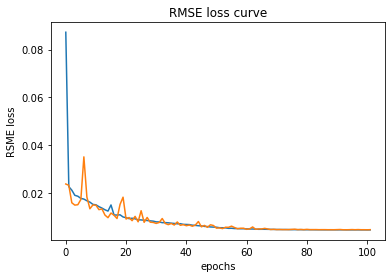

In [24]:
plt.figure()
plt.plot(train_rmse)
plt.plot(valid_rmse)
plt.xlabel('epochs')
plt.ylabel('RSME loss')
plt.title('RMSE loss curve')
plt.savefig('loss_curve_v1.png')
plt.show()

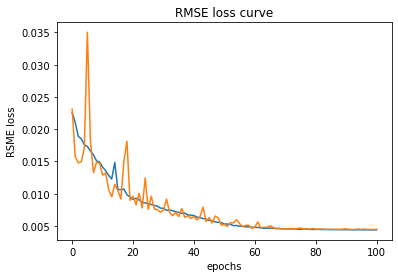

In [25]:
plt.figure()
plt.plot(train_rmse[1:])
plt.plot(valid_rmse[1:])
plt.xlabel('epochs')
plt.ylabel('RSME loss')
plt.title('RMSE loss curve')
plt.savefig('loss_curve_v2.png')
plt.show()

# Evaluation and Submission

In [16]:
test_path = "./val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = best_model(inp).cpu().data.numpy()
        
        # De-Normalization ! 
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(preds)

# Generate Submission File

In [42]:
# Submission Files
sample_sub = pd.read_csv('sample_submission.csv')

In [43]:
# Convert to int
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv('test_submission.csv', index=None)

In [44]:
sub_df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,1713,336,1715,337,1717,338,1716,339,1717,...,1739,359,1738,359,1740,360,1740,361,1743,361
1,10015,725,1229,725,1229,725,1229,725,1229,725,...,724,1227,724,1228,723,1227,723,1227,724,1227
2,10019,573,1245,574,1245,574,1245,574,1244,574,...,580,1242,580,1242,580,1242,580,1241,581,1242
3,10028,1691,315,1692,316,1692,316,1693,317,1694,...,1708,328,1708,328,1709,329,1710,329,1710,330
4,1003,2123,676,2120,676,2119,674,2118,673,2118,...,2092,650,2092,650,2090,649,2090,648,2087,647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,256,805,256,805,256,805,257,805,257,...,262,801,263,801,263,801,263,800,263,800
3196,99,587,1154,587,1153,587,1153,587,1152,588,...,590,1139,589,1138,589,1137,589,1136,589,1136
3197,9905,1755,444,1755,444,1755,444,1755,445,1755,...,1751,452,1751,453,1751,453,1751,453,1751,454
3198,9910,574,1289,574,1288,574,1288,574,1288,574,...,571,1283,571,1283,571,1283,571,1282,571,1282


In [ ]:
# Ensemble Method 